In [26]:
import os
import site
import sqlite3
import sys
import warnings
from time import sleep

import logzero
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from logzero import logger
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import SARIMAX, VAR, acf, adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
from yaml import dump, load, safe_load

In [27]:
plt.rcParams["figure.figsize"] = 30, 25
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelpad"] = 12
plt.rcParams["axes.xmargin"] = 0.01
plt.rcParams["axes.ymargin"] = 0.01

In [28]:
log_path = "logs/"
log_file = "ts_arima.log"

logzero.logfile(log_path + log_file, maxBytes=1e6, backupCount=5, disableStderrLogger=True)
logger.info(f"{log_path}, {log_file}\n")

In [29]:
sys.path.append("../../sql")
import queries

In [30]:
configs = None
try:
    with open("../configs/config.yml", "r") as config_in:
        configs = load(config_in, Loader=yaml.SafeLoader)
        logger.info(f"{configs}\n")
except:
    logger.error(f"config file open failure.")
    exit(1)

cfg_vars = configs["url_variables"]
logger.info(f"variables: {cfg_vars}\n")

years = configs["request_years"]
logger.info(f"years: {years}\n")

db_path = configs["file_paths"]["db_path"]

city = configs["location_info"]["city"]
state = configs["location_info"]["state"]
db_file = city + "-" + state + ".db"

db_table1 = configs["table_names"]["db_table1"]
db_table2 = configs["table_names"]["db_table2"]

logger.info(f"{db_path}, {db_file}")

nrows = configs["num_rows"][0]
logger.info(f"number of rows: {nrows}\n")

In [31]:
conn = sqlite3.connect(db_path + db_file)
cursor = conn.cursor()

In [32]:
cursor.execute(queries.select_distinct_zips)
distinct_zipcodes = cursor.fetchall()
distinct_zipcodes = [z[0] for z in distinct_zipcodes]
logger.info(f"distinct zip codes:\n{distinct_zipcodes}")
print(distinct_zipcodes)

['91708']


In [33]:
zipcode_index = 0
params = {"zipcode": distinct_zipcodes[zipcode_index]}

select_nsr_rows = f"""
SELECT date_time, year, zipcode,
-- Clearsky_DHI, DHI,
Clearsky_DNI, DNI,
Clearsky_GHI, GHI,
Temperature,
Relative_Humidity,
Precipitable_Water,
Wind_Speed,
Wind_Direction
from nsrdb
where zipcode = :zipcode;
"""


df = pd.read_sql(
    select_nsr_rows,
    conn,
    params=params,
    index_col="date_time",
    parse_dates=["date_time"],
)

df.sort_index(axis=0, inplace=True)

In [34]:
df  # .head(5)

,year,zipcode,Clearsky_DNI,DNI,Clearsky_GHI,GHI,Temperature,Relative_Humidity,Precipitable_Water,Wind_Speed,Wind_Direction
date_time,,,,,,,,,,,
1998-01-01 00:30:00,1998,91708,0.0,0.0,0.0,0.0,13.0,65.10,1.548,1.0,86.7
1998-01-01 01:30:00,1998,91708,0.0,0.0,0.0,0.0,13.0,61.26,1.468,1.0,83.5
1998-01-01 02:30:00,1998,91708,0.0,0.0,0.0,0.0,13.0,58.23,1.405,1.0,83.3
1998-01-01 03:30:00,1998,91708,0.0,0.0,0.0,0.0,13.0,56.02,1.367,1.1,85.0
1998-01-01 04:30:00,1998,91708,0.0,0.0,0.0,0.0,13.0,53.99,1.361,1.1,87.7
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:30:00,2020,91708,0.0,0.0,0.0,0.0,8.9,59.76,0.800,1.4,43.0
2020-12-31 20:30:00,2020,91708,0.0,0.0,0.0,0.0,8.2,60.02,0.800,1.5,47.0
2020-12-31 21:30:00,2020,91708,0.0,0.0,0.0,0.0,7.6,60.17,0.800,1.5,49.0


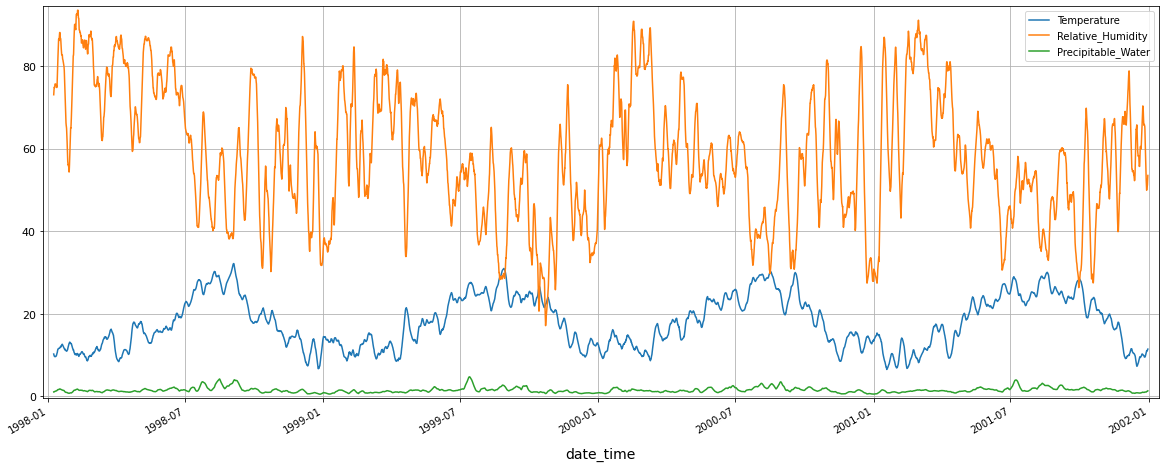

In [35]:
# # compares = ["Clearsky_DHI", "DHI"]
# compares = ["Wind_Speed", "Wind_Direction"]
compares = ["Temperature", "Relative_Humidity", "Precipitable_Water"]
# compares = ["Clearsky_GHI", "GHI"]
# compares = ["Clearsky_DNI", "DNI"]

df.iloc[:35040][compares].rolling(168).mean().plot(figsize=(20, 8))
plt.grid()

In [36]:
df_rsm = df.resample("M").mean().reset_index(drop=False)

In [37]:
df_rsm

,date_time,year,Clearsky_DNI,DNI,Clearsky_GHI,GHI,Temperature,Relative_Humidity,Precipitable_Water,Wind_Speed,Wind_Direction
0,1998-01-31,1998.0,312.725806,193.256720,158.559140,116.268817,11.461022,74.901344,1.196043,1.408737,168.557661
1,1998-02-28,1998.0,330.165179,171.066964,201.436012,136.398810,10.007440,86.479226,1.425155,2.150149,200.181101
2,1998-03-31,1998.0,365.642473,219.232527,261.442204,187.193548,12.858871,76.266237,1.270946,1.910887,182.766129
3,1998-04-30,1998.0,384.641667,292.604167,313.873611,268.347222,13.668056,72.995972,1.137753,1.906944,195.900833
4,1998-05-31,1998.0,399.022849,244.490591,345.922043,257.693548,14.939516,79.635323,1.470833,2.055242,212.420430
...,...,...,...,...,...,...,...,...,...,...,...
271,2020-08-31,2020.0,372.713710,356.186828,313.321237,307.096774,29.165591,35.584583,2.411290,1.757930,194.243280
272,2020-09-30,2020.0,285.506944,277.145833,255.193056,250.990278,28.539306,27.949014,1.710972,1.436528,156.625000
273,2020-10-31,2020.0,329.411290,280.205645,217.068548,195.552419,23.991935,36.020228,1.315323,1.522446,158.978495
274,2020-11-30,2020.0,324.305556,292.790278,170.163889,160.405556,16.961389,40.650194,1.097222,1.663889,133.398611


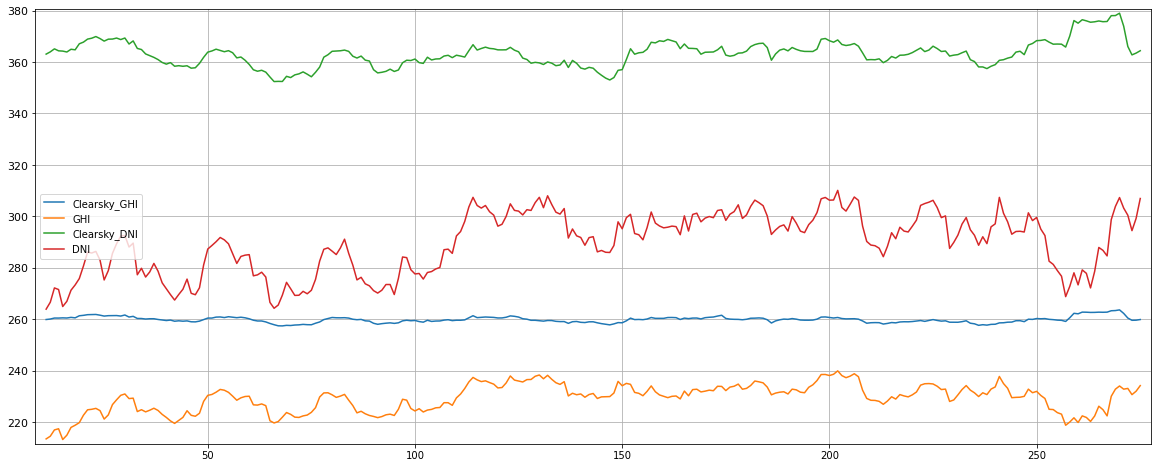

In [38]:
# # compares = ["Clearsky_DHI", "DHI"]
# # compares = ["Wind_Speed", "Wind_Direction"]

compares_G = ["Clearsky_GHI", "GHI"]
compares_D = ["Clearsky_DNI", "DNI"]
compares_A = ["Temperature", "Relative_Humidity", "Precipitable_Water"]

df_rsm[compares_G + compares_D].rolling(12).mean().plot(figsize=(20, 8))
plt.grid()

In [74]:
df = df_rsm.set_index("date_time")
df.drop("year", axis=1, inplace=True)

In [75]:
df.head(12)

,Clearsky_DNI,DNI,Clearsky_GHI,GHI,Temperature,Relative_Humidity,Precipitable_Water,Wind_Speed,Wind_Direction
date_time,,,,,,,,,
1998-01-31,312.725806,193.256720,158.559140,116.268817,11.461022,74.901344,1.196043,1.408737,168.557661
1998-02-28,330.165179,171.066964,201.436012,136.398810,10.007440,86.479226,1.425155,2.150149,200.181101
1998-03-31,365.642473,219.232527,261.442204,187.193548,12.858871,76.266237,1.270946,1.910887,182.766129
1998-04-30,384.641667,292.604167,313.873611,268.347222,13.668056,72.995972,1.137753,1.906944,195.900833
1998-05-31,399.022849,244.490591,345.922043,257.693548,14.939516,79.635323,1.470833,2.055242,212.420430
1998-06-30,420.594444,298.448611,359.752778,285.702778,18.956944,75.187986,1.695065,1.981250,213.332500
1998-07-31,422.337366,367.219086,350.692204,324.485215,25.607527,55.649624,2.118876,1.649731,183.846774
1998-08-31,383.077957,360.974462,315.567204,305.711022,28.625000,45.821519,2.760534,1.598925,181.600538
1998-09-30,356.202778,237.081944,272.205556,210.887500,22.769444,62.461861,2.145356,1.623472,188.478194


In [81]:
df_diff = df.diff(periods=12).dropna()

In [82]:
df_diff.head(12)

,Clearsky_DNI,DNI,Clearsky_GHI,GHI,Temperature,Relative_Humidity,Precipitable_Water,Wind_Speed,Wind_Direction
date_time,,,,,,,,,
1999-01-31,10.501344,32.280914,2.251344,12.520161,0.654570,-17.019772,-0.199542,0.408468,-28.790323
1999-02-28,14.052083,66.775298,4.608631,29.418155,1.947917,-26.963542,-0.382122,-0.350149,-31.887798
1999-03-31,-9.200269,-7.459677,-0.100806,5.444892,-1.146505,-4.330161,-0.237155,-0.004973,22.676344
1999-04-30,-1.273611,-79.272222,0.962500,-50.287500,-0.030556,-9.398403,-0.001318,0.236389,9.087917
1999-05-31,-4.162634,24.235215,-0.690860,20.252688,2.939516,-18.292554,0.046942,-0.153898,-5.476478
1999-06-30,12.780556,51.841667,2.968056,36.334722,2.425000,-20.695500,-0.204576,-0.062500,-13.351250
1999-07-31,-2.563172,24.620968,-2.176075,10.145161,-0.436828,-5.750457,0.368899,0.093683,17.538172
1999-08-31,28.024194,29.663978,9.630376,11.962366,-2.319892,-4.760202,-0.963745,0.150134,-0.688710
1999-09-30,7.762500,58.522222,2.040278,34.734722,1.162500,-12.369847,-0.181749,-0.098889,-10.906111


In [83]:
columns = df_diff.columns.tolist()
# columns = columns[2:]
print(columns)

['Clearsky_DNI', 'DNI', 'Clearsky_GHI', 'GHI', 'Temperature', 'Relative_Humidity', 'Precipitable_Water', 'Wind_Speed', 'Wind_Direction']


In [84]:
adf_tests = []

for col in columns:
    adf_tests.append(adfuller(df_diff[col], autolag="AIC"))

for col, test in zip(columns, adf_tests):
    print(f"p-value: {test[1]} for {col}")

p-value: 3.5311965904820766e-09 for Clearsky_DNI
p-value: 1.7709893699765527e-12 for DNI
p-value: 1.2869301165826418e-09 for Clearsky_GHI
p-value: 1.4947386907307695e-08 for GHI
p-value: 6.883639460888032e-09 for Temperature
p-value: 1.5733593587337496e-08 for Relative_Humidity
p-value: 1.1830948839118172e-11 for Precipitable_Water
p-value: 1.1430272132452451e-10 for Wind_Speed
p-value: 1.896324252289453e-09 for Wind_Direction


In [88]:
kpss_tests = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for col in columns:
        kpss_tests.append(kpss(df_diff[col], regression="ct", nlags="auto"))

for col, test in zip(columns, kpss_tests):
    print(f"p-value: {test[1]} for {col}")

p-value: 0.1 for Clearsky_DNI
p-value: 0.1 for DNI
p-value: 0.1 for Clearsky_GHI
p-value: 0.1 for GHI
p-value: 0.1 for Temperature
p-value: 0.1 for Relative_Humidity
p-value: 0.1 for Precipitable_Water
p-value: 0.1 for Wind_Speed
p-value: 0.1 for Wind_Direction


In [89]:
def plot_autocorr(df, columns, column_idx, max_lag):

    fig, ax = plt.subplots(3, 2, figsize=(20, 20))
    ax = ax.flatten()

    for idx, col in enumerate(column_idx):
        plot_acf(
            df[columns[col]],
            ax[idx],
            lags=max_lag,
            title=f"{columns[col]} Autocorrelation",
        )
        ax[idx].set_xlabel(r"Lag")
        ax[idx].set_ylabel(r"Correlation")
        ax[idx].grid()

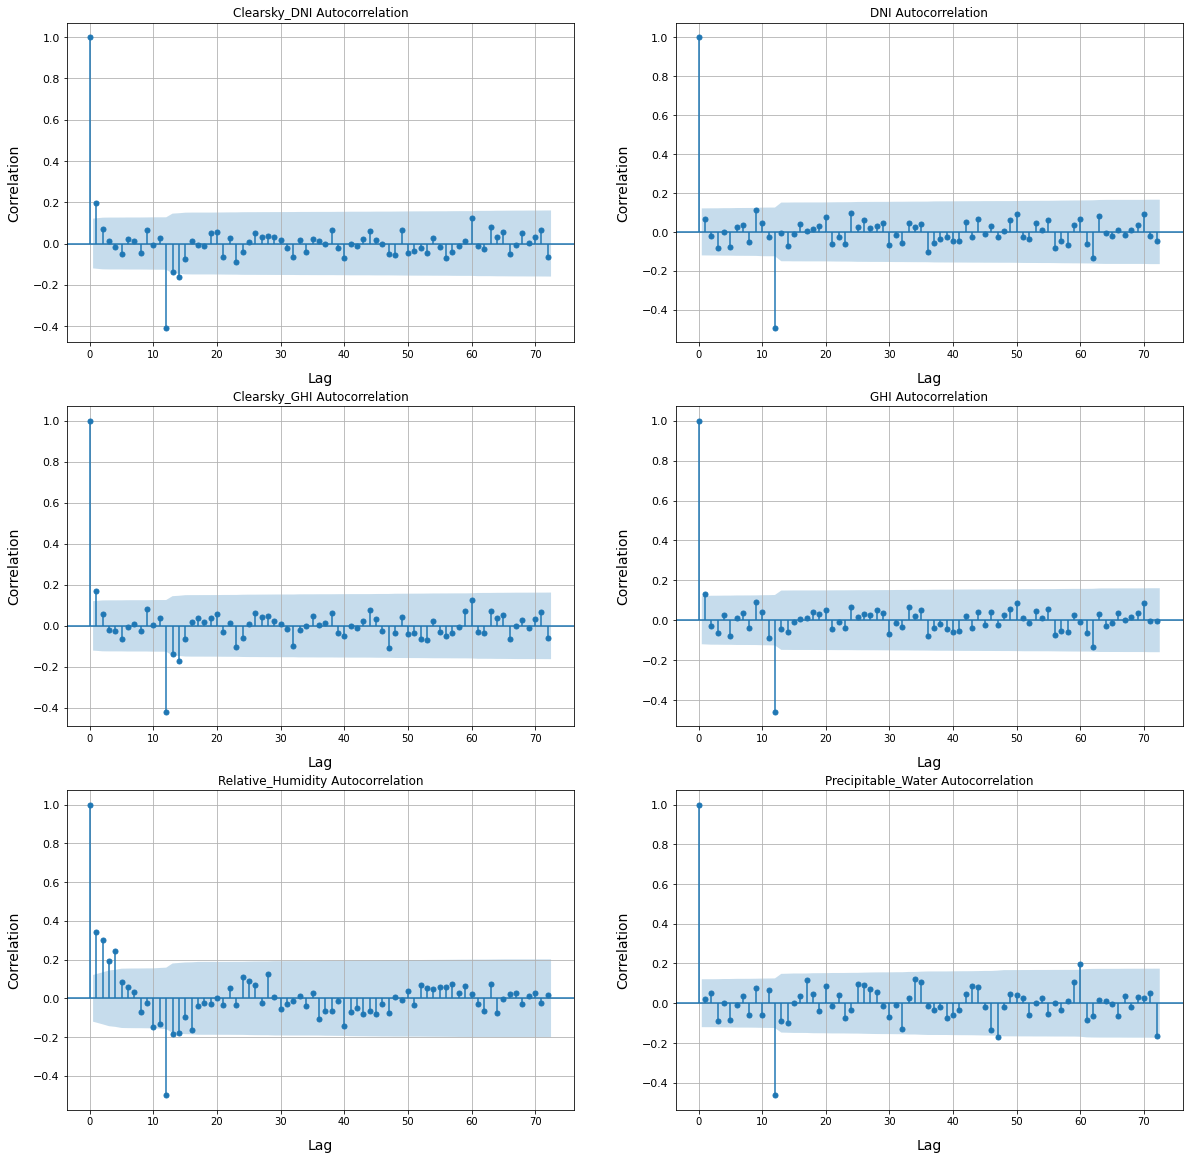

In [90]:
plot_autocorr(df_diff, columns, [0, 1, 2, 3, 5, 6], 72)

In [91]:
def plot_part_autocorr(df, columns, column_idx, max_lag):

    fig, ax = plt.subplots(3, 2, figsize=(20, 20))
    ax = ax.flatten()

    for idx, col in enumerate(column_idx):
        plot_pacf(
            df[columns[col]],
            ax[idx],
            lags=max_lag,
            title=f"{columns[col]} Autocorrelation",
        )
        ax[idx].set_xlabel(r"Lag")
        ax[idx].set_ylabel(r"Correlation")
        ax[idx].grid()

/opt/miniconda3/envs/mads1m/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/opt/miniconda3/envs/mads1m/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/opt/miniconda3/envs/mads1m/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/opt/miniconda3/envs/mads1m/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/opt/miniconda3/envs/mads1m/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/opt/miniconda3/envs/mads1m/lib/python3.8/site-packages/statsmodels/regression/linear_mode

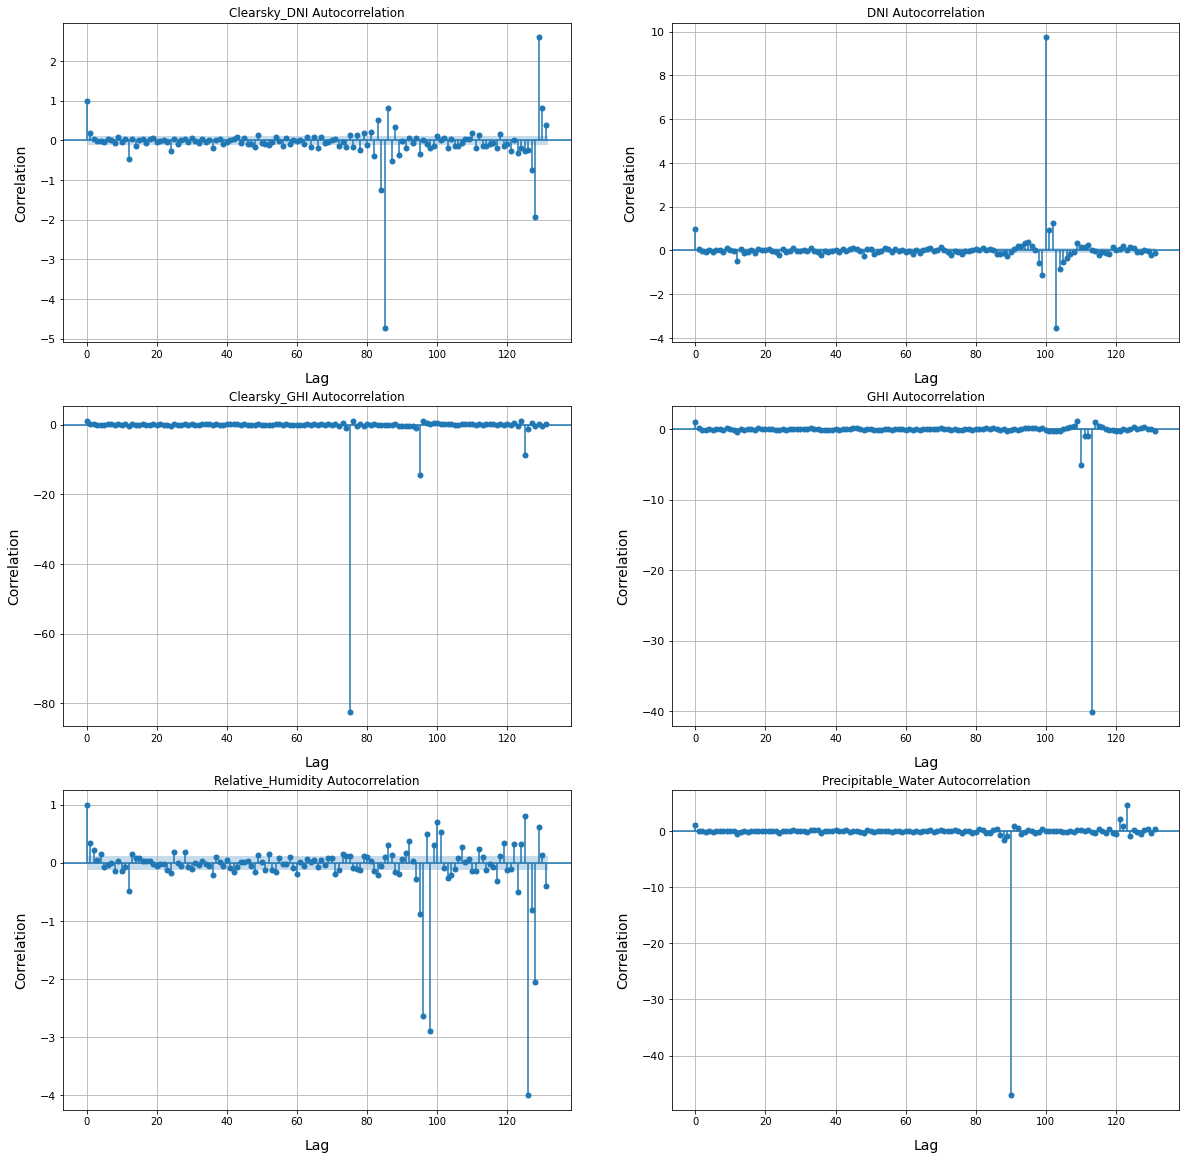

In [98]:
plot_part_autocorr(df_diff, columns, [0, 1, 2, 3, 5, 6], 131)